In [78]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nltk
import glob
import os
from tqdm.notebook import tqdm
import time

path = '/Users/Svesketerning/Google-Drev/experiments'
timestr = time.strftime("%Y%m%d-%H%M")

In [36]:
#explanation_df = pd.read_feather('/Users/Svesketerning/Google-Drev/experiments/database-files/explain_fullraw20210518-1551.feather')
print(LatestExplanationBranchRawFile)

/Users/Svesketerning/Google-Drev/experiments/explanation-data/explain_branch_raw20210520-1034.feather


In [37]:
LatestDatabaseFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/arxiv_extended_database*'),key=os.path.getctime)
df_arxiv = pd.read_feather(LatestDatabaseFile)

LatestExplanationFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/explain_fullraw*'),key=os.path.getctime)
explanation_df = pd.read_feather(LatestExplanationFile)

LatestExplanationBranchRawFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/explanation-data/explain_branch_raw*'),key=os.path.getctime)
explain_branch_raw = pd.read_feather(LatestExplanationBranchRawFile)

### Takes a categorization of branches and collects them

In [25]:
# You have to load df_arxiv and explain_branch_raw from with those exact names
def all_branches_count(focusword_df,focusword_branch_raw,df_arxiv, focus_contexts = ['outer','theorem', 'meta', 'proof', 'other']):
    contexts = focus_contexts
    result = []
    for i in focusword_df['mainmathcat'].unique():
        branch_count = 0
        for j in contexts:
            branch_count += df_arxiv.loc[(df_arxiv['mainmathcat'] == i)][j].sum()
        result.append({'mainmathcat': i, 'word count': branch_count})
    branch_count_df = pd.concat([pd.DataFrame(result[i], index=['mainmathcat']) for i in range(len(result))])
    branch_merged_df = pd.merge(focusword_branch_raw,branch_count_df, on = ['mainmathcat'])
    frequency = [] 
    for i in range(len(branch_merged_df)):
        frequency.append(branch_merged_df['focuswords'][i]/branch_merged_df['word count'][i]* 10**6)
    branch_merged_df["frequency"] = np.array(frequency)
    return branch_merged_df

# Given a categorization, it takes a focusword_df and context specification to give a compunded list.
def branch_categorization(focusword_df,focusword_branch_raw,focus_contexts = ['outer','theorem', 'meta', 'proof', 'other'],
   branch_categories = [['math.AP','math.RT'],['math.HO','math.MP']]):
    contexts = focus_contexts
    branch_merged_df = all_branches_count(focusword_df,focusword_branch_raw,focus_contexts = contexts)
    result = []
    for i in branch_categories:
        a = branch_merged_df[branch_merged_df['mainmathcat'].isin(i)]['focuswords'].sum()
        b = branch_merged_df[branch_merged_df['mainmathcat'].isin(i)]['word count'].sum()
        c = a/b* 10**6
        result.append({'categories': i, 'focuswords': a, 'word count': b, "frequency": c})
    df = pd.DataFrame(result)
    return df

# Prints a table of p-values for insepction 
def branch_cat_pvalues(branch_cat_df):
    result = []
    for i in range(len(branch_cat_df)):
        a = [branch_cat_df.iloc[i,:]['focuswords'].item(),
             branch_cat_df.iloc[i,:]['word count'].item()]
        for j in range(len(branch_cat_df)):
            b = [branch_cat_df.iloc[j,:]['focuswords'].item(),
             branch_cat_df.iloc[j,:]['word count'].item()]
            oddsratio, pvalue = stats.fisher_exact([a,b])
            result.append(pvalue)
    pvalues_df = pd.DataFrame(np.array(result).reshape(len(branch_cat_df),len(branch_cat_df)),
                         index = list(map(str, branch_cat_df['categories'])),
                         columns = list(map(str, branch_cat_df['categories'])))
    #pvalues_df = pvalues_df.style.applymap(lambda x: 'color: red' if x <= 0.05 and x <=5 else 'color: black')
    return pvalues_df

#Prints basic seaborn plot
def basic_seaborn_plot(df): # Categories and frequency hardcoded
    df['categories'] = df['categories'].map(str)
    df = df.sort_values('frequency', ascending = False)
    sns.set_style("whitegrid")
    g = sns.catplot(
    data=df, kind="bar",
    x="categories", y="frequency",
    ci="sd", palette=sns.color_palette("winter_r"), alpha=.6, height=6,aspect=4)
    g.despine(left=True)
    g.set_xticklabels(rotation=30)
    return g


# Make the focusword_branch_raw as requested in all_branches count
def raw_wordcount_branch(focusword_df):
    result = []
    contexts = ['outer','theorem', 'meta', 'proof', 'other'] # Non functional!
    for i in focusword_df['mainmathcat'].unique():
        a =len(focusword_df.loc[(focusword_df['mainmathcat'] == i)])
        result.append({'mainmathcat': i, 'focuswords': a})
    df = pd.concat([pd.DataFrame(result[i], index=[0]) for i in range(len(result))])
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    return df

#### Better cut of branches includes a total!

In [38]:
branches_counts_freq = all_branches_count(explanation_df,explain_branch_raw,df_arxiv)
branches_counts_freq = branches_counts_freq.sort_values('frequency')
branch_count = 0
for i in explanation_df['mainmathcat'].unique():
    for j in ['outer','theorem', 'meta', 'proof', 'other']:
        branch_count += df_arxiv.loc[(df_arxiv['mainmathcat'] == i)][j].sum()
a = explain_branch_raw['focuswords'].sum()/branch_count * 10**6
df = pd.DataFrame([['Total',
                     explain_branch_raw['focuswords'].sum(),
                     branch_count,
                    a]], columns=['mainmathcat','focuswords','word count','frequency'])
branches_counts_freq = pd.concat([branches_counts_freq,df])
branches_counts_freq = branches_counts_freq.reset_index(drop = True)
branches_counts_freq['frequency'] = branches_counts_freq['frequency'].round(2)

#branches_counts_freq.to_latex(path+'/tex/explain_branch_count_and_freq'+timestr+'.tex', index = False)

In [39]:
branches_counts_freq

,mainmathcat,focuswords,word count,frequency
0,math.GN,14,399554,35.04
1,math.RA,129,1797704,71.76
2,math.FA,251,3329663,75.38
3,math.CO,671,8763100,76.57
4,math.GM,28,339841,82.39
5,math.CA,182,2076603,87.64
6,math.AP,1021,11168840,91.42
7,math.AC,119,1270226,93.68
8,math.IT,393,4049863,97.04
9,math.OC,579,5800806,99.81


## Ramos better categorization

In [4]:
LatestRamosExplanationFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/explain_ramos_fullraw*'),key=os.path.getctime)
ramos_explanation_df = pd.read_feather(LatestRamosExplanationFile)

LatestRamosFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/ramos2009a_arxiv_contexts*'),key=os.path.getctime)
df_ramos_contexts = pd.read_feather(LatestRamosFile)

LatestRamosDatabaseFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/ramos2009a_arxiv_extended_database*'),key=os.path.getctime)
df_arxiv_ramos = pd.read_feather(LatestRamosDatabaseFile)

LatestRamosExplanationBranchRawFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/explanation-data/ramos_explain_branch_raw*'),key=os.path.getctime)
ramos_explain_branch_raw = pd.read_feather(LatestRamosExplanationBranchRawFile)

In [7]:
branches_counts_freq = all_branches_count(ramos_explanation_df,ramos_explain_branch_raw,df_arxiv_ramos) 
branches_counts_freq = branches_counts_freq.sort_values('frequency')
branch_count = 0
for i in ramos_explanation_df['mainmathcat'].unique():
    for j in ['outer','theorem', 'meta', 'proof', 'other']:
        branch_count += df_arxiv_ramos.loc[(df_arxiv_ramos['mainmathcat'] == i)][j].sum()
a = ramos_explain_branch_raw['focuswords'].sum()/branch_count * 10**6
df = pd.DataFrame([['Total',
                     ramos_explain_branch_raw['focuswords'].sum(),
                     branch_count,
                    a]], columns=['mainmathcat','focuswords','word count','frequency'])
branches_counts_freq = pd.concat([branches_counts_freq,df])
branches_counts_freq = branches_counts_freq.reset_index(drop = True)
branches_counts_freq['frequency'] = branches_counts_freq['frequency'].round(2)
branches_counts_freq
#branches_counts_freq.to_latex(path+'/tex/explain_branch_count_and_freq'+timestr+'.tex', index = False)

,mainmathcat,focuswords,word count,frequency
0,math.GN,14,309777,45.19
1,math.GR,188,2719492,69.13
2,math.LO,75,1016894,73.75
3,math.FA,139,1817676,76.47
4,math.GM,15,188648,79.51
5,math.CA,127,1394801,91.05
6,math.CO,364,3864609,94.19
7,math.MG,67,677606,98.88
8,math.OA,177,1562211,113.30
9,math.IT,352,3070116,114.65


In [75]:
#import sys
#!{sys.executable} -m pip install textdistance
import textdistance # Check whether or not the order of the branches are similar.
import random
ramos_list
my_list
textdistance.jaro_winkler(ramos_list,my_list)
random_list = branches_counts_freq.mainmathcat.to_list()
random_list.remove('Total')
random_list = random.shuffle(random_list)
textdistance.jaro_winkler(random_list,my_list)

0

In [27]:
[a,b]
theta_hat = test.iloc[0,1]*(test.iloc[1,2]-test.iloc[1,1])/((test.iloc[0,2]-test.iloc[0,1])*test.iloc[1,1])
print(np.exp(np.log(theta_hat) + st.norm.ppf(.975) * np.log(1/test.iloc[0,1]+1/test.iloc[1,1]
                                                            +1/(test.iloc[1,2]-test.iloc[1,1])
                                                            +1/(test.iloc[0,2]-test.iloc[0,1]))),
      np.exp(np.log(theta_hat) - st.norm.ppf(.975) * np.log(1/test.iloc[0,1]+1/test.iloc[1,1]
                                                            +1/(test.iloc[1,2]-test.iloc[1,1])
                                                            +1/(test.iloc[0,2]-test.iloc[0,1])))
     )
chi2, p, dof, ex = st.chi2_contingency([a,b], correction=False, lambda_=None)
#oddsratio, pvalue = stats.fisher_exact([a,b])
#pvalue

0.00012867252475467228 6215.685203059727


#### Categorization from Alex and Jonathan 

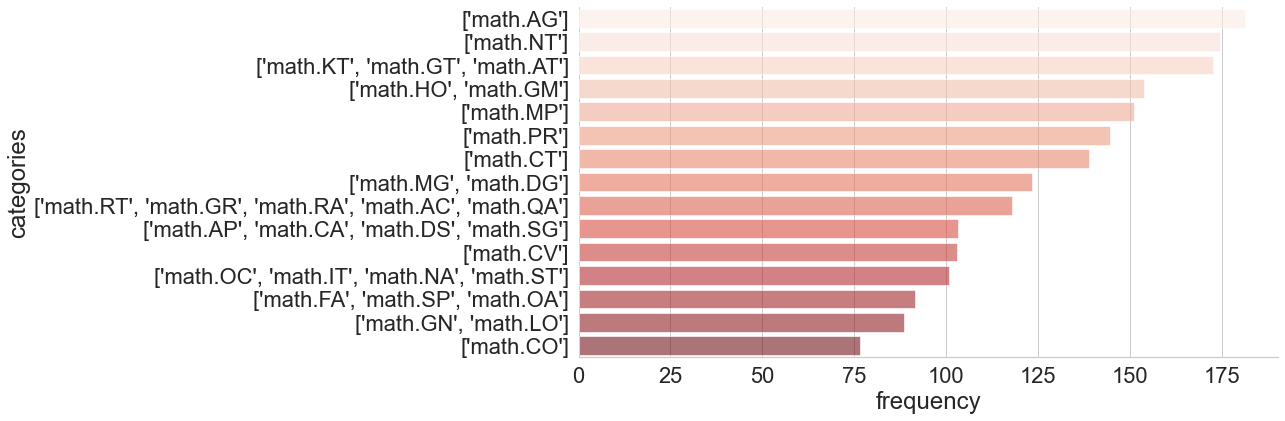

In [77]:
def basic_seaborn_plot(df): # Categories and frequency hardcoded
    df['categories'] = df['categories'].map(str)
    df = df.sort_values('frequency', ascending = False)
    sns.set(font_scale = 2)
    sns.set_style("whitegrid")
    g = sns.catplot(
    data=df, kind="bar",
    y="categories", x="frequency",
    ci="sd", palette=sns.color_palette("Reds", n_colors=15),
    alpha=.6, height=6, aspect=3)
    g.despine(left=True)
    return g


alex_jon_categories = [['math.NT'],['math.CT'],['math.AG'],['math.CO'],
                            ['math.AP','math.CA','math.DS','math.SG'], ['math.CV'],
                            ['math.MP'],['math.PR'],['math.KT','math.GT','math.AT'],
                            ['math.HO','math.GM'],['math.OC','math.IT', 'math.NA','math.ST'],
                            ['math.MG','math.DG'],['math.FA','math.SP','math.OA'],
                            ['math.GN','math.LO'],['math.RT','math.GR','math.RA','math.AC','math.QA']]
# Taken from photo
alex_jon_df = branch_categorization(explanation_df,explain_branch_raw, 
                      focus_contexts = ['outer','theorem', 'meta', 'proof', 'other'],
                      branch_categories = alex_jon_categories)
sns_plot = basic_seaborn_plot(alex_jon_df)
sns_plot.savefig(path+"/figures/explain_alex_jonathan_categories"+timestr+".pdf")

#### (Ramos et al., 2019) categorization based on their intuitive mathmathematical activities.

In [8]:
# Taken from explain_words_extract
def word_extract(dataframe_context,focus_words):
    result = []
    #contexts = [x for x in dataframe_context.columns]
    contexts = ['outer', 'theorem', 'meta', 'proof', 'other']
    for index in tqdm(range(len(dataframe_context.index))):
        for c in contexts:
            sentences = nltk.sent_tokenize(dataframe_context[c][index])
            for sent in sentences:
                sent = sent.lower()
                overlap = [x for x in focus_words if x in sent]
                if len(overlap)>0:
                    arc_id = df_contexts['id'][index]
                    result.append({'id':arc_id, # NOTE THAT YOU HAVE TO LOAD ARXIV DATABASE FILE AS df_arxiv!!
                                   'mainmathcat': df_arxiv.loc[df_arxiv['id'] == arc_id]['mainmathcat'].item(),
                                   'context': c, 'sentence': sent, 'focuswords': ",".join(overlap)})
    df = pd.DataFrame(result)
    df = df.set_index('id')
    return df 
LatestContextFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/arxiv_contexts*'),key=os.path.getctime)
df_contexts = pd.read_feather(LatestContextFile)

In [9]:
# DONT USE
### Define words
conjecture_words = ['conjecture']
define_words = ['define','definition']
model_words = ['model']
prove_words = ['proof','prove']
show_words = ['show']
solve_words = ['solve','solution']
ramos_words = conjecture_words + define_words + model_words + prove_words + show_words + solve_words
ramos_raw_df = word_extract(df_contexts,ramos_words)
ramos_raw_df = ramos_raw_df.reset_index()
ramos_raw_df.to_feather(path+'/database-files/ramos_fullraw'+timestr+'.feather') # save to feather

In [16]:
conjecture_raw_df = word_extract(df_contexts,conjecture_words)
define_raw_df = word_extract(df_contexts,define_words)
proof_raw_df = word_extract(df_contexts,prove_words)
model_raw_df = word_extract(df_contexts,model_words)
show_raw_df = word_extract(df_contexts,show_words)
solve_raw_df = word_extract(df_contexts,solve_words)

conjecture_raw_df = conjecture_raw_df.reset_index()
define_raw_df = define_raw_df.reset_index()
model_raw_df = model_raw_df.reset_index()
show_raw_df = show_raw_df.reset_index()
solve_raw_df = solve_raw_df.reset_index()
proof_raw_df = proof_raw_df.reset_index()

conjecture_raw_df.to_feather(path+'/database-files/conjecture_fullraw'+timestr+'.feather') # save as feather
define_raw_df.to_feather(path+'/database-files/define_fullraw'+timestr+'.feather') # save as feather
model_raw_df.to_feather(path+'/database-files/model_fullraw'+timestr+'.feather') # save as feather
show_raw_df.to_feather(path+'/database-files/show_fullraw'+timestr+'.feather') # save as feather
solve_raw_df.to_feather(path+'/database-files/solve_fullraw'+timestr+'.feather') # save as feather
proof_raw_df.to_feather(path+'/database-files/prove_fullraw'+timestr+'.feather') # save as feather

In [82]:
LatestProofFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/proof_fullraw*'),key=os.path.getctime)
proof_raw_df = pd.read_feather(LatestProofFile)

LatestConjectureFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/conjecture_fullraw*'),key=os.path.getctime)
conjecture_raw_df = pd.read_feather(LatestConjectureFile)

LatestDefineFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/define_fullraw*'),key=os.path.getctime)
define_raw_df = pd.read_feather(LatestDefineFile)

LatestModelFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/model_fullraw*'),key=os.path.getctime)
model_raw_df = pd.read_feather(LatestModelFile)

LatestShowFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/show_fullraw*'),key=os.path.getctime)
show_raw_df = pd.read_feather(LatestShowFile)

LatestSolveFile = max(glob.iglob('/Users/Svesketerning/Google-Drev/experiments/database-files/solve_fullraw*'),key=os.path.getctime)
solve_raw_df = pd.read_feather(LatestSolveFile)

In [84]:
frames = [conjecture_raw_df,define_raw_df,model_raw_df,show_raw_df,solve_raw_df,proof_raw_df]
names = ['conjecture','define','model','show','solve','proof']
ramos_frames = []
for i in range(len(frames)):
    df = all_branches_count(frames[i],raw_wordcount_branch(frames[i]),
                            focus_contexts = ['outer','meta'])
    df = df.drop(labels=["focuswords","word count"], axis = 1)
    df = df.rename(columns = {'frequency': names[i]})
    ramos_frames.append(df)

ramos_df = ramos_frames[0]
for i in range(len(ramos_frames)-1):
    ramos_df = pd.merge(ramos_df,ramos_frames[i+1])

# Used for easier indexing 
ramos_df = ramos_df.set_index('mainmathcat')

##### Models

In [85]:
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
calculate_kmo(ramos_df)

(array([0.5496209 , 0.74683629, 0.55090471, 0.63436333, 0.58605616,
        0.59321196]), 0.6203544072363105)

In [86]:
from sklearn.cluster import KMeans # Our clustering algorithm
from sklearn.decomposition import PCA # Needed for dimension reduction
from sklearn.preprocessing import StandardScaler
from matplotlib import colors as mcolors
std_ramos_df = StandardScaler().fit_transform(ramos_df) #normalizing

pca = PCA(n_components=len(frames))
principalComponents = pca.fit_transform(std_ramos_df)

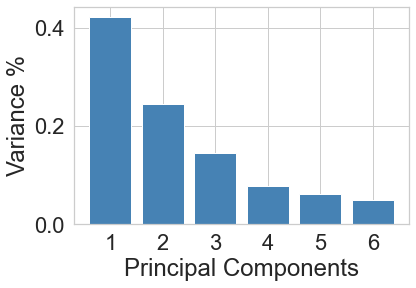

In [87]:
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='steelblue')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)
# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

In [95]:
0.421269+0.24543332

0.66670232

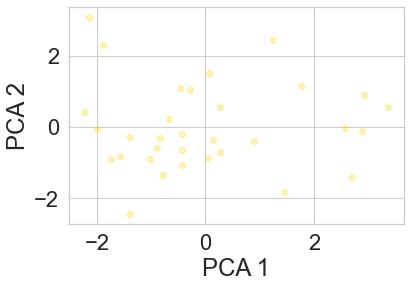

In [88]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

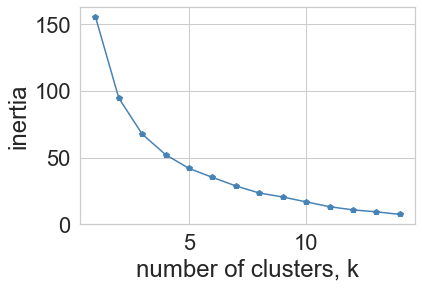

In [89]:
inertias = []

# Creating 10 K-Mean models while varying the number of clusters (k)
for k in range(1,15):
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(range(1,15), inertias, '-p', color='steelblue')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

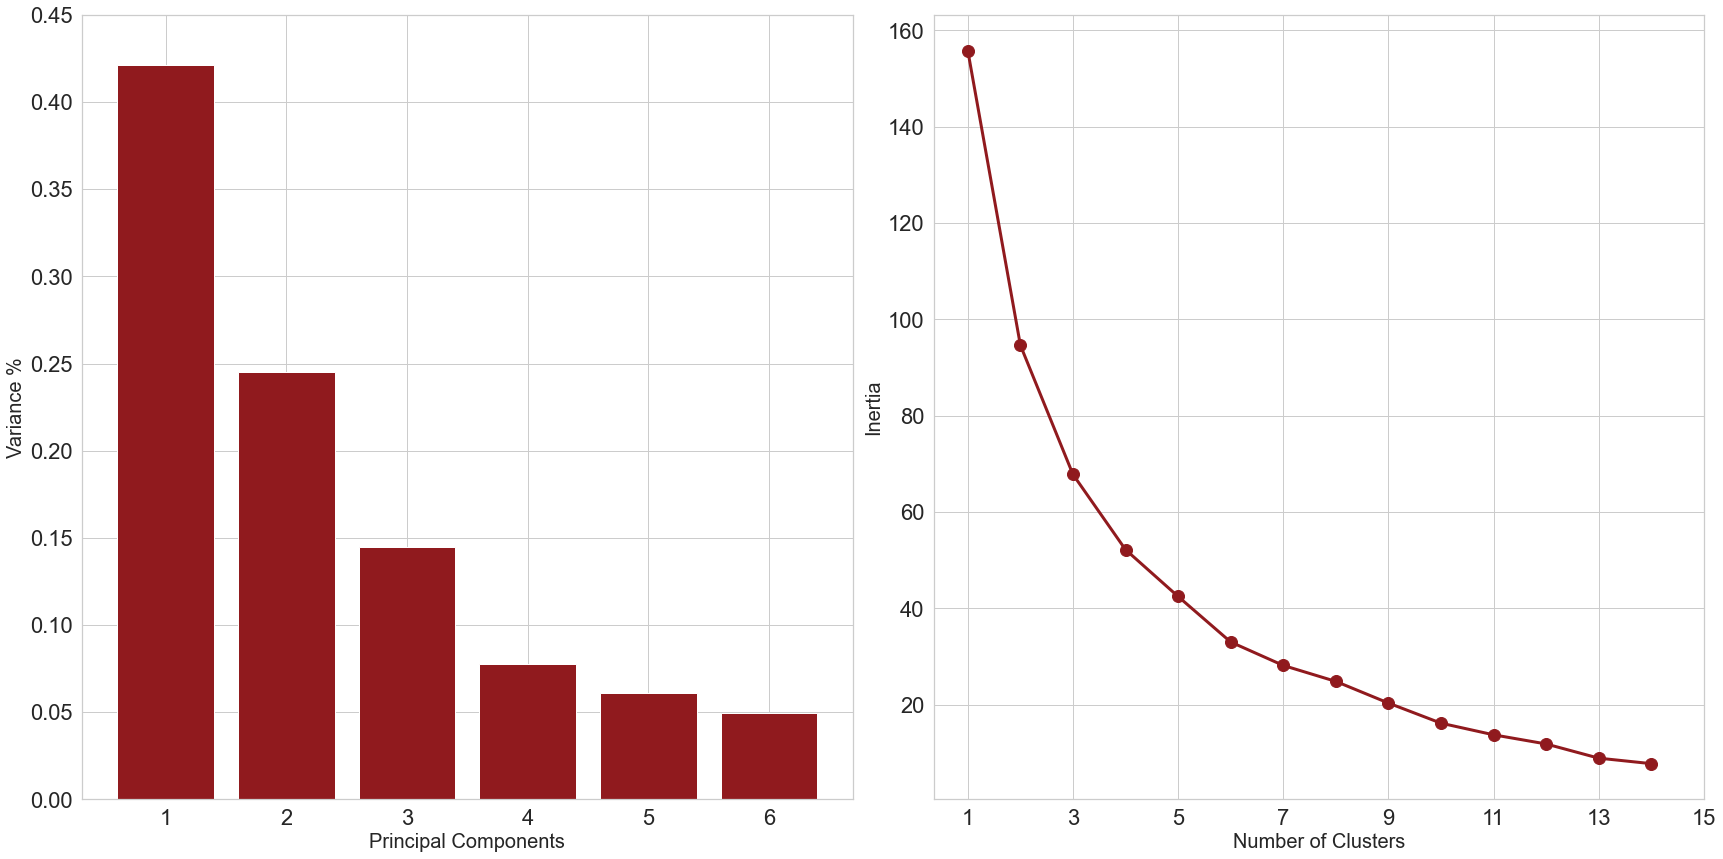

In [91]:
font_size = 20
plt.figure(figsize = (24,12))
plt.subplot(1, 2, 1)  

PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='#901A1E')
plt.xlabel('Principal Components', fontsize = font_size )
plt.ylabel('Variance %', fontsize = font_size )
plt.xticks(PC)
plt.yticks(np.arange(0.0, 0.5, 0.05))
plt.subplot(1, 2, 2)  

inertias = []

# Creating 10 K-Mean models while varying the number of clusters (k)
for k in range(1,15):
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(range(1,15), inertias, '-bo', color='#901A1E',  linewidth=3, markersize=12)
plt.xlabel('Number of Clusters', fontsize = font_size )
plt.ylabel('Inertia', fontsize = font_size )


plt.xticks(np.arange(1, 16, 2.0))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(path+'/figures/pca-elbow-method'+timestr+'.pdf')
plt.show()

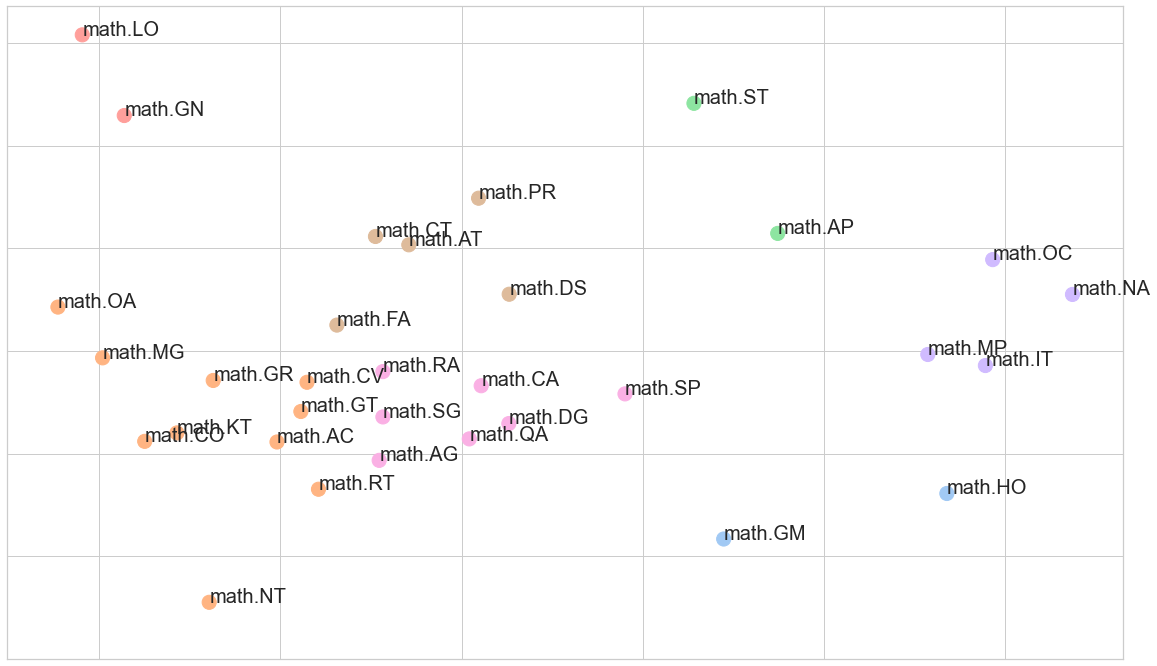

In [133]:
model = KMeans(n_clusters=7)
model.fit(PCA_components.iloc[:,:2])
#sns.color_palette("winter_r", n_colors=len(theorem_classification.unique()))
labels = model.predict(PCA_components.iloc[:,:2])

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(20)
my_cmap = ListedColormap(sns.color_palette("pastel", n_colors=max(labels)+1).as_hex())

plt.scatter(PCA_components[0], PCA_components[1], c=labels, 
            s = 200, cmap = my_cmap)
for i, txt in enumerate(ramos_df.index.tolist()):
    ax.annotate(txt, (PCA_components[0][i], PCA_components[1][i]), fontsize = 20)
plt.xticks(ticks=list(range(-2, 4)), labels=[])
plt.yticks(ticks=list(range(-3, 4)), labels=[])
plt.show()
fig.savefig(path+'/figures/pca-kmeans-classification'+timestr+'.pdf')

#### UMAP instead of PCA

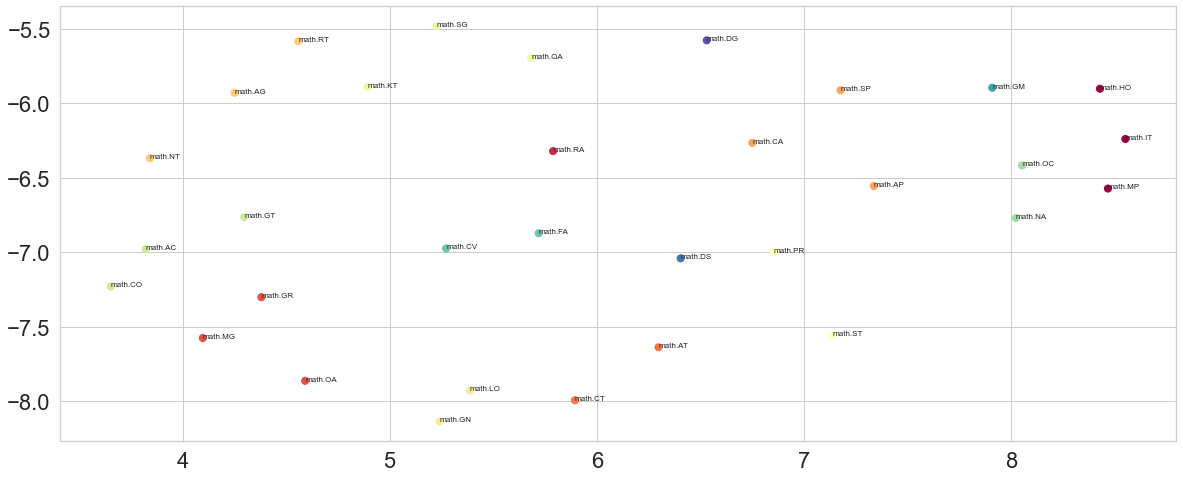

In [121]:
import umap.umap_ as umap 
import sklearn.cluster as cluster

reducer = umap.UMAP()
no = 15
clusterable_embedding = umap.UMAP( # Labels depends
    n_neighbors= 20,
    min_dist=0.0,
    n_components= no ,
    random_state=42,
).fit_transform(std_ramos_df)
standard_embedding = umap.UMAP(random_state=42).fit_transform(clusterable_embedding)

labels = kmeans_labels = cluster.KMeans(n_clusters=no).fit_predict(clusterable_embedding)
clustered = (labels >= 0)

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels,
            s=50,
            cmap='Spectral');
for i, txt in enumerate(ramos_df.index.tolist()):
    ax.annotate(txt, standard_embedding[i], fontsize = 8)

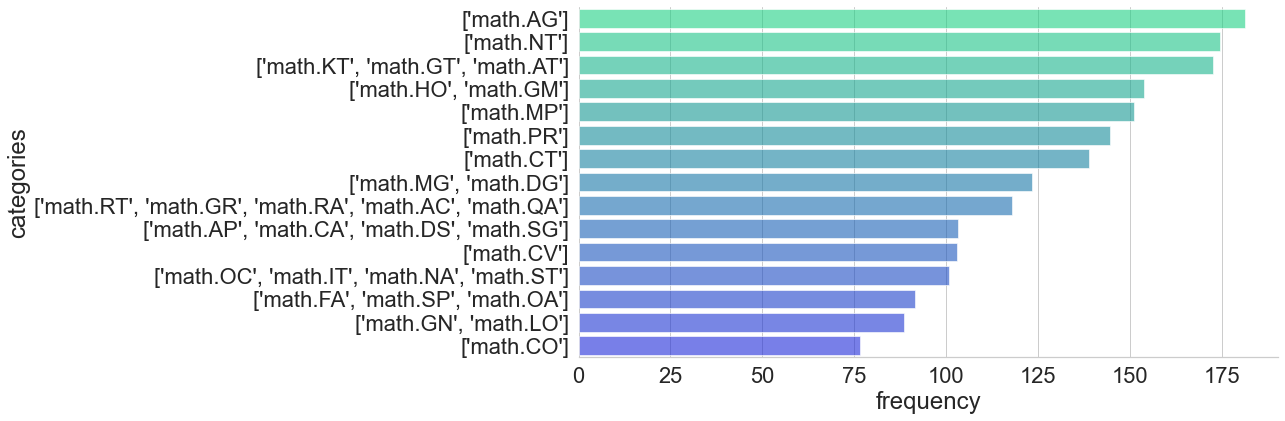

In [122]:
alex_jon_categories = [['math.NT'],['math.CT'],['math.AG'],['math.CO'],
                            ['math.AP','math.CA','math.DS','math.SG'], ['math.CV'],
                            ['math.MP'],['math.PR'],['math.KT','math.GT','math.AT'],
                            ['math.HO','math.GM'],['math.OC','math.IT', 'math.NA','math.ST'],
                            ['math.MG','math.DG'],['math.FA','math.SP','math.OA'],
                            ['math.GN','math.LO'],['math.RT','math.GR','math.RA','math.AC','math.QA']]
# Taken from photo
alex_jon_df = branch_categorization(explanation_df,explain_branch_raw, 
                      focus_contexts = ['outer','theorem', 'meta', 'proof', 'other'],
                      branch_categories = alex_jon_categories)
sns_plot = basic_seaborn_plot(alex_jon_df)
sns_plot.savefig(path+"/figures/explain_alex_jonathan_categories"+timestr+".pdf")

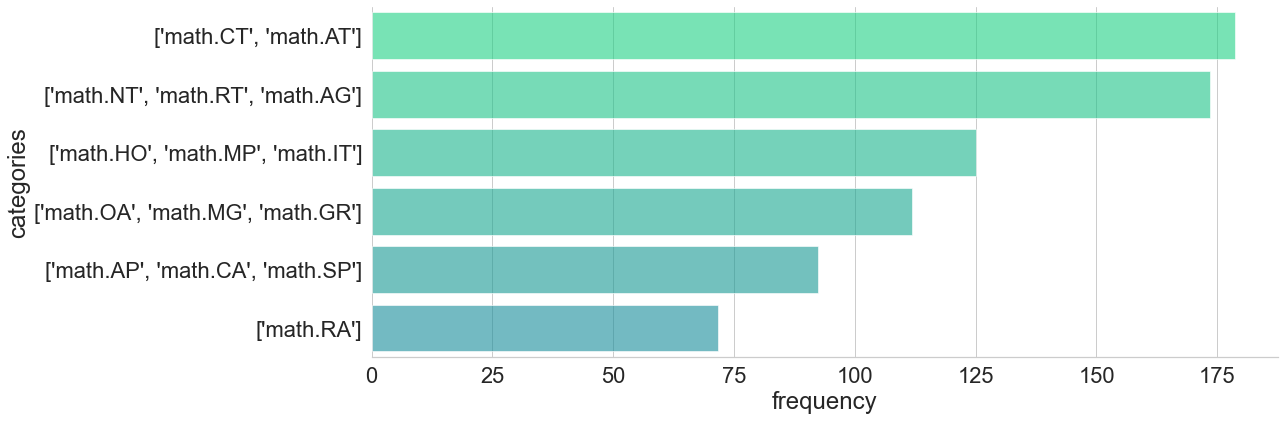

In [123]:
qualitative_cat = [[] for _ in range(6)]
for i in list(zip(labels,ramos_df.index.tolist())):
    for j in range(6):
        if j == i[0]:
            qualitative_cat[j].append(i[1])
quali_df =branch_categorization(explanation_df,explain_branch_raw, 
                      focus_contexts = ['outer','theorem', 'meta', 'proof', 'other'],
                      branch_categories = qualitative_cat)
quali_plot = basic_seaborn_plot(quali_df)
sns_plot.savefig(path+"/figures/explain_qualitative_categories"+timestr+".pdf")